# Formalization of prediction about transition rate decodability

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import sys
from sklearn.linear_model import Ridge
from my_stats import get_r2

from disp import set_plot

DT = .01
T = 30  # trial duration
NT = int(T/DT)

F_MAX = 30
NTAU_TR = 50
TAU_TR = np.logspace(np.log10(.1), np.log10(30), NTAU_TR)

N = 2
TAU_R = np.array([30, 120])

### Create stimuli with varied transition rates

In [2]:
t = np.arange(NT)*DT

NRTR = 10  # number of transition rates
R_TR = np.linspace(.1, 1, NRTR)

NRPT = 30

NSTIM = NRTR*NRPT

NSTIM_SAVE = 4
ISTIM_SAVE = np.round(np.linspace(0, NSTIM-1, NSTIM_SAVE)).astype(int)

r_trs = np.nan*np.zeros(NSTIM)
trs = np.zeros((NSTIM, NT))
i_ins = np.nan*np.zeros(trs.shape)

c = 0
for r_tr in R_TR:
    for cstim in range(NRPT):
        r_trs[c] = r_tr
        trs[c, 1:] = np.random.rand(NT-1) < r_tr*DT
        i_ins[c, :] = np.cumsum(trs[c, :]) % 2
        
        c += 1

In [3]:
# get estimate rates at end of each repeat
r_tr_ests = np.nan * np.zeros((NSTIM, len(TAU_TR)))

for ctr, tr in enumerate(trs):
    temp = np.zeros(len(TAU_TR))
    for ct in range(1, NT):
        temp = temp + DT/TAU_TR*(-temp + tr[ct])
    
    r_tr_ests[ctr] = temp
    
r_tr_ests /= DT

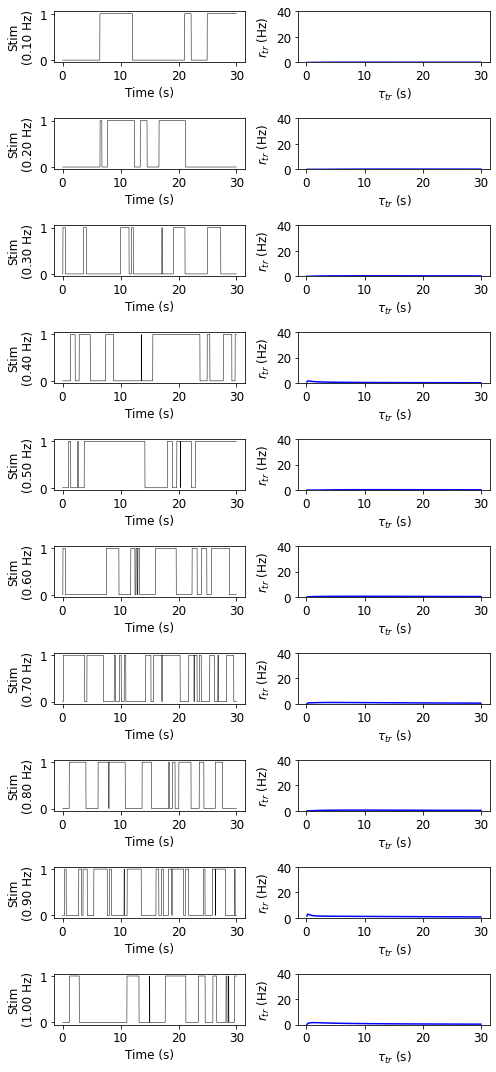

In [4]:
# plot several example stimuli
NSTIM_PLOT = 10
ISTIM_PLOT = np.round(np.linspace(0, NSTIM-1, NSTIM_PLOT)).astype(int)

fig, axs = plt.subplots(NSTIM_PLOT, 2, figsize=(7, 1.5*NSTIM_PLOT), tight_layout=True)
for cistim, istim in enumerate(ISTIM_PLOT):
    axs[cistim, 0].plot(t, i_ins[istim], lw=.5, c='k')
    axs[cistim, 0].set_xlabel('Time (s)')
    axs[cistim, 0].set_ylabel(f'Stim\n({r_trs[istim]:.2f} Hz)')
    axs[cistim, 1].plot(TAU_TR, r_tr_ests[istim], c='b')
    axs[cistim, 1].set_ylim(0, 40)
    axs[cistim, 1].set_xlabel(r'$\tau_{tr}$ (s)')
    axs[cistim, 1].set_ylabel(r'$r_{tr}$ (Hz)')
    
for ax in axs.flatten():
    set_plot(ax, font_size=12)

### Linear neural response

In [5]:
r_lin = np.nan*np.zeros((NSTIM, N))
r_lin_save = []

for cstim, i_in in enumerate(i_ins):
    
    r_temp = np.nan*np.zeros((NT, N))
    r_temp[0, :] = 0
    
    for ct in range(1, NT):
        r_temp[ct, :] = r_temp[ct-1, :] + DT/TAU_R*(-r_temp[ct-1, :] + i_in[ct])
    
    r_lin[cstim, :] = r_temp[-1, :].copy()
    
    if cstim in ISTIM_SAVE:
        r_lin_save.append(r_temp.copy())

In [6]:
# decode
mtrain = np.arange(0, NSTIM, 2)
mtest = np.arange(1, NSTIM, 2)

x_train = r_lin[mtrain, :]
x_test = r_lin[mtest, :]

r2_train_lin = np.nan*np.zeros(len(TAU_TR))
r2_test_lin = np.nan*np.zeros(len(TAU_TR))

for ctau_tr, tau_tr in enumerate(TAU_TR):
    y_train = r_tr_ests[:, ctau_tr][mtrain]
    
    rgr = Ridge(alpha=.1).fit(x_train, y_train)
    
    y_hat_train = rgr.predict(x_train)
    
    r2_train_lin[ctau_tr] = get_r2(y_train, y_hat_train)
    
    y_test = r_tr_ests[:, ctau_tr][mtest]
    y_hat_test = rgr.predict(x_test)
    
    r2_test_lin[ctau_tr] = get_r2(y_test, y_hat_test)

### Multiplicative adaptation neural response

$$\tau_r \frac{dr}{dt} = -r + (1-a)I(t)$$

$$\tau_a \frac{da}{dt} = -a + I(t)$$

In [7]:
TAU_R_MA = TAU_R
TAU_A_MA = np.array([.5, .5])

r_ma = np.nan*np.zeros((NSTIM, 2))
r_ma_save = []

for cstim, i_in in enumerate(i_ins):
    
    r_temp = np.nan*np.zeros((NT, 2))
    r_temp[0, :] = 0
    
    a_temp = np.zeros(2)
    
    for ct in range(1, NT):
        r_temp[ct, :] = r_temp[ct-1, :] + DT/TAU_R_MA*(-r_temp[ct-1, :] + (1-a_temp)*i_in[ct])
        a_temp = a_temp + DT/TAU_A_MA*(-a_temp + i_in[ct])
        
    r_ma[cstim, :] = r_temp[-1, :].copy()
    
    if cstim in ISTIM_SAVE:
        r_ma_save.append(r_temp.copy())

In [8]:
# decode
mtrain = np.arange(0, NSTIM, 2)
mtest = np.arange(1, NSTIM, 2)

x_train = r_ma[mtrain, :]
x_test = r_ma[mtest, :]

r2_train_ma = np.nan*np.zeros(len(TAU_TR))
r2_test_ma = np.nan*np.zeros(len(TAU_TR))

for ctau_tr, tau_tr in enumerate(TAU_TR):
    y_train = r_tr_ests[:, ctau_tr][mtrain]
    
    rgr = Ridge(alpha=.1).fit(x_train, y_train)
    
    y_hat_train = rgr.predict(x_train)
    
    r2_train_ma[ctau_tr] = get_r2(y_train, y_hat_train)
    
    y_test = r_tr_ests[:, ctau_tr][mtest]
    y_hat_test = rgr.predict(x_test)
    
    r2_test_ma[ctau_tr] = get_r2(y_test, y_hat_test)

## Example responses of linear vs MA populations

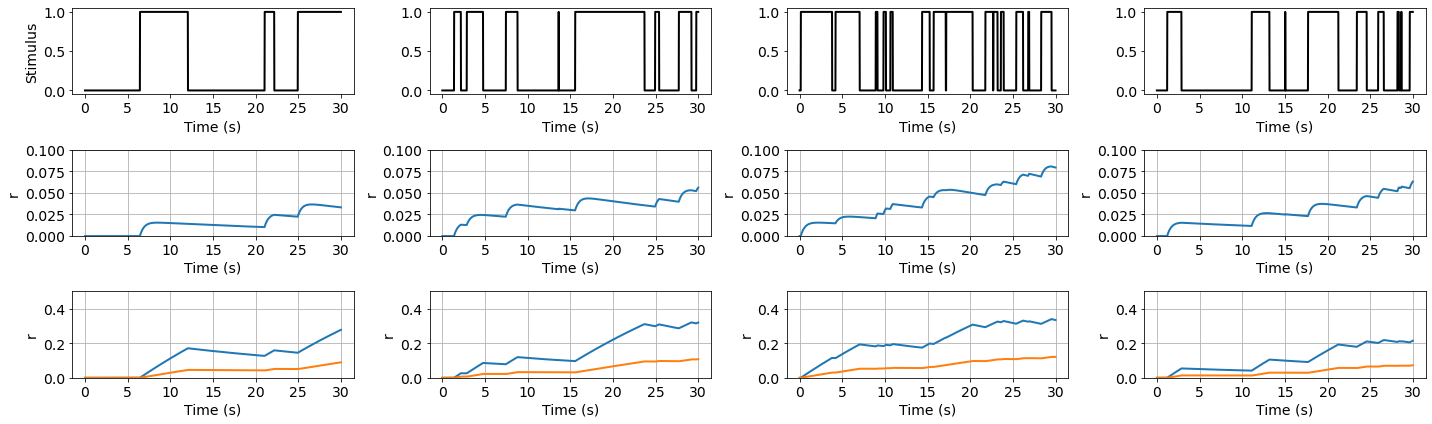

In [9]:
fig, axs = plt.subplots(3, NSTIM_SAVE, figsize=(20, 6), tight_layout=True)
for ax, istim in zip(axs[0, :], ISTIM_SAVE):
    ax.plot(t, i_ins[istim], lw=2, c='k')
    ax.set_xlabel('Time (s)')
    
axs[0, 0].set_ylabel('Stimulus')

for ax_row, r_ppln_save, title in zip(axs[1:, :], [r_ma_save, r_lin_save], ['MA', 'Lin']):
    for ax, istim, r_ppln in zip(ax_row, ISTIM_PLOT, r_ppln_save):
        if title == 'Lin':
            ax.plot(t, r_ppln, lw=2)
        elif title == 'MA':
            ax.plot(t, r_ppln[:, 0], lw=2)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('r')
#         ax.set_title(title)
        ax.grid()
        
for ax in axs[1, :]:
    ax.set_ylim(0, .1)
    
for ax in axs[2, :]:
    ax.set_ylim(0, 0.5)
    
for ax in axs:
    set_plot(ax, font_size=14)

## Decodability of transition rate from neural population

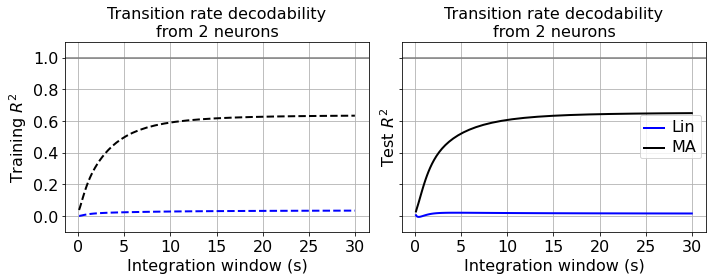

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True, tight_layout=True)
axs[0].plot(TAU_TR, r2_train_lin, lw=2, ls='--', c='b')
axs[0].plot(TAU_TR, r2_train_ma, lw=2, ls='--', c='k')
axs[0].set_ylabel(r'Training $R^2$')

axs[1].plot(TAU_TR, r2_test_lin, lw=2, c='b')
axs[1].plot(TAU_TR, r2_test_ma, lw=2, c='k')
axs[1].set_ylabel(r'Test $R^2$')
axs[1].legend(['Lin', 'MA'])

for ax in axs:
    ax.axhline(1, c='gray')
    set_plot(ax, y_lim=(-.1, 1.1), x_label=r'Integration window (s)', title=f'Transition rate decodability\nfrom {N} neurons', font_size=16)
    ax.grid()